In [1]:
import urllib
import pandas as pd
import numpy as np
import functools
import subprocess
import os
import json


def load_info(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return f.read().decode('utf-8')

def load_csv(name, read_csv_args):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return pd.read_csv(f, **read_csv_args)

def load_label(name):
    with urllib.request.urlopen(ESL_datasets_url+name) as f:
        return np.array([l.strip().decode('utf-8') for l in f.readlines()])
    
def to_array(d):
    if isinstance(d, dict):
        return {k: to_array(v) for k,v in d.items()}
    if isinstance(d, list):
        return np.array(d)
    return d

def load_rda(name):
    cmd = subprocess.run(
               ['Rscript', '--vanilla', 
                '-e' ,
                f'load(url("{ESL_datasets_url}{name}")); jsonlite::write_json(as.list(environment()), stdout())'],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE
              )
    if cmd.returncode:
        print(cmd.stderr.decode('utf-8'))
        raise ValueError
    else:
        data = json.loads(cmd.stdout.decode('utf-8'))
        return to_array(data)


ESL_datasets_url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/'

ESL_datasets = {
        'prostate': {
          'meta': functools.partial(load_info, name='prostate.info.txt'), 
          'data': functools.partial(load_csv, name='prostate.data', 
                                    read_csv_args=dict(sep="\t", index_col=0))
        },
        'ozone': {
          'meta': functools.partial(load_info, name='ozone.info.txt'), 
          'data': functools.partial(load_csv, name='ozone.data', 
                                    read_csv_args=dict(sep="\t"))
        },
        'spam': {
          'meta': functools.partial(load_info, name='spam.info.txt'), 
          'data': functools.partial(load_csv, name='spam.data', 
                                    read_csv_args=dict(sep=' ', index_col=None, header=None))
        },
        'phoneme': {
          'meta': functools.partial(load_info, name='phoneme.info.txt'), 
          'data': functools.partial(load_csv, name='phoneme.data', 
                                    read_csv_args=dict(sep=',', index_col=0))
        },
        'nci_microarray': {
          'meta': functools.partial(load_info, name='nci.info.txt'), 
          'data': functools.partial(load_csv, name='nci.data.csv', 
                                    read_csv_args=dict(sep=',', index_col=0)),
          'label': functools.partial(load_label, name='nci.label'),
        },
        'sa_heart_disease': {
          'meta': functools.partial(load_info, name='SAheart.info.txt'), 
          'data': functools.partial(load_csv, name='SAheart.data', 
                                    read_csv_args=dict(sep=',', header=None))
        },    
        'mixture':{
          'meta': functools.partial(load_info, name='mixture.example.info.txt'), 
          'data': functools.partial(load_rda, name='ESL.mixture.rda')
        },
    }   
    
class Dataset:
    def __init__(self, kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)
    def __repr__(self):
        return self.meta + '\n' + repr(self.data)
    def __str__(self):
        return str(self.data)
    
    
def load_ESL_dataset(name):
    return Dataset({k: v() for k, v in ESL_datasets[name].items()})


In [4]:
# def load_uci_data(name=spambase):
#     baseurl = f"http://archive.ics.uci.edu/ml/machine-learning-databases/{name}/{name}."
#     files = { '__doc__' : 'DOCUMENTATION',
#               'data' : 'data',
#               'feature_names' : 'names'
#             }
#     def download(url):
#         urllib
#     return Dataset({k:  for k, v in files.items()})
        

In [2]:
def ISLR2data(name):
    import io
    import zipfile
    import urllib
    url = ("https://www.statlearning.com/s/"
           "ALL-CSV-FILES-2nd-Edition-corrected.zip")
    zipdata = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(io.BytesIO(zipdata)) as zf:
        for zi in zf.filelist:
            if name in zi.filename:
                with zf.open(zi) as f:
                    df = pd.read_csv(f, index_col=0)
                break
    return df

def ISLRdata(name):
    import statsmodels.datasets as smd
    data = smd.get_rdataset(name, 'ISLR')
    for k in ['__doc__', 'title', 'package']:
        setattr(data.data, k, getattr(data, k, ''))
    return data.data
    
smarket = ISLRdata('Smarket')
print(smarket.title, smarket.package)
print(smarket.__doc__)


S&P Stock Market Data ISLR
.. container::

   ======= ===============
   Smarket R Documentation
   ======= ===============

   .. rubric:: S&P Stock Market Data
      :name: sp-stock-market-data

   .. rubric:: Description
      :name: description

   Daily percentage returns for the S&P 500 stock index between 2001 and
   2005.

   .. rubric:: Usage
      :name: usage

   ::

      Smarket

   .. rubric:: Format
      :name: format

   A data frame with 1250 observations on the following 9 variables.

   ``Year``
      The year that the observation was recorded

   ``Lag1``
      Percentage return for previous day

   ``Lag2``
      Percentage return for 2 days previous

   ``Lag3``
      Percentage return for 3 days previous

   ``Lag4``
      Percentage return for 4 days previous

   ``Lag5``
      Percentage return for 5 days previous

   ``Volume``
      Volume of shares traded (number of daily shares traded in
      billions)

   ``Today``
      Percentage return for today

   `

In [3]:
spam = load_ESL_dataset('spam')

In [4]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [5]:
spam.data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [6]:
import sklearn.datasets as skd
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
mixture = load_ESL_dataset('mixture')

(-2.6, 4.2, -2.0, 2.9)

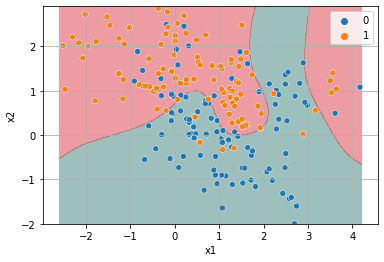

In [11]:

X = pd.DataFrame(mixture.data['ESL.mixture']['x'], columns=['x1','x2'])
posterior = mixture.data['ESL.mixture']['prob'].reshape(99,-1)
x1 = mixture.data['ESL.mixture']['px1']
x2 = mixture.data['ESL.mixture']['px2']
plt.contourf(x1, x2, posterior, levels=[0,0.5,1],
             colors = sns.diverging_palette(180,10,n=2),
             alpha=0.5)
sns.scatterplot(x='x1',y='x2', hue = mixture.data['ESL.mixture']['y'], 
                data=X)
plt.grid()

plt.axis('equal')

In [12]:
y = mixture.data['ESL.mixture']['y']
X_grid = pd.DataFrame(mixture.data['ESL.mixture']['xnew'], 
                               columns=['x1', 'x2'])

knn = KNeighborsClassifier(n_neighbors=30).fit(X=X.values, y=y)
z_new =knn.predict_proba(X=X_grid.values)[:,1].reshape(99,-1)


In [13]:
def plot_mixture(data, k=None, n=201):
    y = data['y']
    x1 = data['px1']
    x2 = data['px2']
    X = pd.DataFrame(data['x'], columns=['x1', 'x2'])
    if k is None:
        z = data['prob'].reshape(99,-1)
    else:
        x1 = np.linspace(x1.min(), x1.max(), n)
        x2 = np.linspace(x2.min(), x2.max(), n)
        X_grid = np.stack(np.meshgrid(x1, x2))
        sh = X_grid.shape[1:]
        #X_grid = pd.DataFrame(data['xnew'], 
        #                      columns=['x1', 'x2'])
        knn = KNeighborsClassifier(n_neighbors=k).fit(X=X.values, y=y)
        z = knn.predict_proba(X=X_grid.reshape(2,-1).T)
        z = z[:,1].reshape(sh)
            
    plt.contourf(x1, x2, z, levels=[0,0.5,1],
                 colors = sns.diverging_palette(180,10,n=2),
                 alpha=0.5)
    sns.scatterplot(x='x1',y='x2', hue = y, data=X)
    #plt.grid()
    plt.axis('equal')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.axis('off')

    

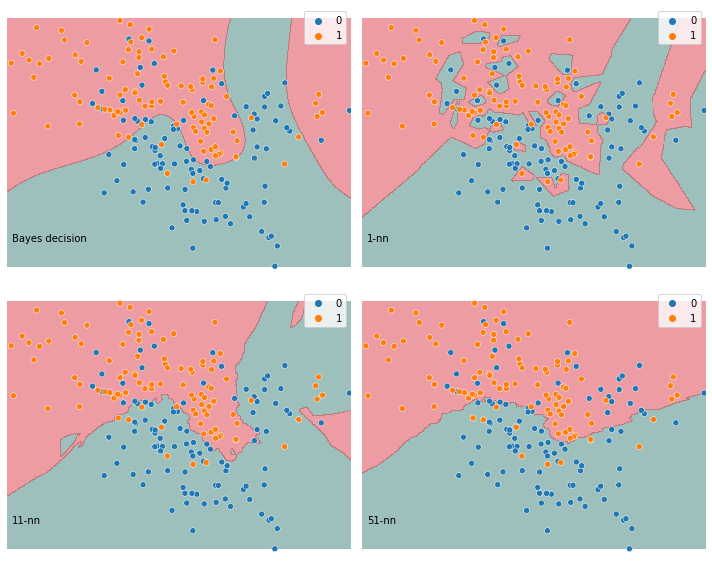

In [14]:
plt.figure(figsize=(10, 4*2),tight_layout=True)
for i, k in enumerate([None, 1, 11, 51]):
    plt.subplot(2,2,i+1)
    plot_mixture(mixture.data['ESL.mixture'], k=k, n=501)
    # if k is not None:
    plt.text(-2.5, -1.5, f'{k}-nn' if k is not None else 'Bayes decision')
plt.savefig(f'11-19-knn.pdf')
    #plt.show()

In [15]:
mixture.data['ESL.mixture']['means']

array([[-0.2534,  1.7415],
       [ 0.2667,  0.3712],
       [ 2.0965,  1.2334],
       [-0.0613, -0.2087],
       [ 2.7035,  0.5968],
       [ 2.3772, -1.1864],
       [ 1.0569, -0.6839],
       [ 0.5789, -0.0683],
       [ 0.6243,  0.5987],
       [ 1.6734, -0.2893],
       [ 1.1994,  0.2484],
       [-0.3026,  0.9454],
       [ 0.0573,  2.4197],
       [ 1.3293,  0.8192],
       [-0.0794,  1.6138],
       [ 3.5079,  1.053 ],
       [ 1.6139,  0.6717],
       [ 1.0075,  1.3683],
       [-0.4546,  1.0861],
       [-1.798 ,  1.9298]])

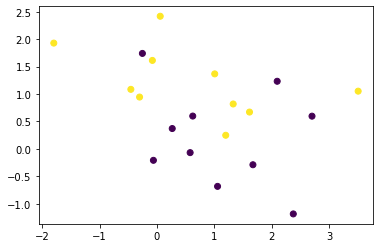

In [16]:
plt.scatter(*mixture.data['ESL.mixture']['means'].T, 
            c=np.concatenate((np.zeros(10),np.ones(10))))

In [8]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

              precision    recall  f1-score   support

           0      0.751     0.766     0.758      5025
           1      0.759     0.743     0.751      4975

    accuracy                          0.755     10000
   macro avg      0.755     0.755     0.755     10000
weighted avg      0.755     0.755     0.755     10000



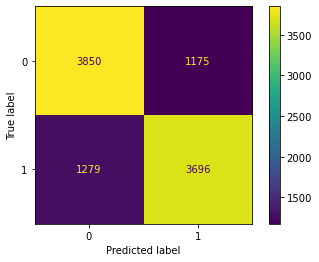

In [8]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

k=11
data = mixture.data['ESL.mixture']
knn = KNeighborsClassifier(n_neighbors=k).fit(data['x'], data['y'])
means = data['means']
idx = np.random.randint(20,size=10000)
m = means[idx]
X_test = m + (0.2**0.5)*np.random.normal(size=m.shape)
y_test = 1*(idx>9)
print(classification_report(y_pred=knn.predict(X_test), y_true=y_test, 
                            digits=3))
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.show()

In [18]:
np.stack(np.meshgrid(np.linspace(-2,2,101),np.linspace(-2,2,101))).reshape(2,-1).shape

(2, 10201)

In [9]:
import sklearn.datasets as skd

In [10]:
spam = skd.fetch_openml('spambase')

In [11]:
spam['frame']

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61.0,278.0,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101.0,1028.0,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485.0,2259.0,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40.0,191.0,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40.0,191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3.0,88.0,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4.0,14.0,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6.0,118.0,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5.0,78.0,0


In [23]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB, 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [42]:
# sns.pairplot(spam['frame'].iloc(1)[:5])
(spam['frame']!=0).mean(axis=0)

word_freq_make                0.228863
word_freq_address             0.195175
word_freq_all                 0.410346
word_freq_3d                  0.010215
word_freq_our                 0.379917
word_freq_over                0.217127
word_freq_remove              0.175397
word_freq_internet            0.179092
word_freq_order               0.168007
word_freq_mail                0.282982
word_freq_receive             0.154097
word_freq_will                0.505325
word_freq_people              0.185177
word_freq_report              0.077592
word_freq_addresses           0.073028
word_freq_free                0.269724
word_freq_business            0.209302
word_freq_email               0.225603
word_freq_you                 0.701369
word_freq_credit              0.092154
word_freq_your                0.526625
word_freq_font                0.025429
word_freq_000                 0.147577
word_freq_money               0.159748
word_freq_hp                  0.236905
word_freq_hpl            

In [29]:
train_df,test_df = train_test_split(spam['frame'], test_size=0.2, shuffle=True, random_state=1)

def Xyspam(df):
    return df.drop(columns=['class']), df['class']

def print_report(model, test):
    X,y = Xyspam(test)
    y_pred = model.predict(X)
    cm = pd.DataFrame(confusion_matrix(y_pred=y_pred, y_true=y), columns=model.classes_).set_index(model.classes_)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    cr = classification_report(y_pred=y_pred, y_true=y)
    print(cm)
    print(cr)
    return (cm, cr)


In [45]:
logistic = make_pipeline(StandardScaler(),
                         LogisticRegression(penalty='none', solver='newton-cg'))
logistic.fit(*Xyspam(train_df))

cm, cr = print_report(logistic, test_df)



Predicted    0    1
True               
0          541   23
1           42  315
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       564
           1       0.93      0.88      0.91       357

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



In [134]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=16, shuffle=True)


In [112]:
logistic_l2_cv = make_pipeline(StandardScaler(), 
                               LogisticRegressionCV(Cs=[0.1, 1, 2.5, 5, 7.5, 10, 15, 20, 50, 100, 1000], # #[0.1,1,5,10,50,100], 
                                                    penalty='l2', 
                                                    cv=cv, 
                                                    solver = 'liblinear',
                                                    refit=True)).fit(*Xyspam(train_df)) #spam['frame']))

In [114]:
print(logistic_l2_cv[1].C_)

[10.]


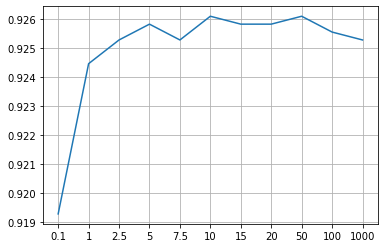

In [113]:
plt.plot(logistic_l2_cv[1].scores_['1'].mean(axis=0)) #.T) #.mean(axis=0))
plt.grid()
plt.xticks(*zip(*enumerate(logistic_l2_cv[1].Cs)))
plt.show()

In [133]:
logistic = make_pipeline(StandardScaler(),
                         LogisticRegression(penalty='l2', C=10, solver='newton-cg'))
logistic.fit(*Xyspam(train_df))

cm, cr = print_report(logistic, test_df)


Predicted    0    1
True               
0          542   22
1           39  318
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       564
           1       0.94      0.89      0.91       357

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



In [115]:
logistic_l1_cv = make_pipeline(StandardScaler(), 
                               LogisticRegressionCV(Cs=[0.1, 1, 2.5, 5, 7.5, 10, 15, 20, 50, 100, 1000], # #[0.1,1,5,10,50,100], 
                                                    penalty='l1', 
                                                    cv=cv, 
                                                    solver = 'liblinear',
                                                    refit=True)).fit(*Xyspam(train_df)) #spam['frame']))
print(logistic_l1_cv[1].C_)

[5.]


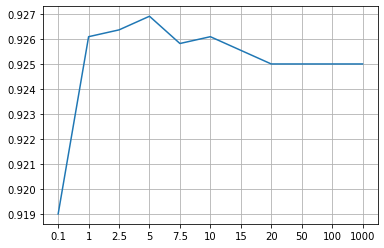

[[ 7  3  1  0  0  0  0  1  0  0  0]
 [ 7  3  3  1  1  1  0  0  0  0  0]
 [ 8  3  1  0  0  0  0  0  0  0  0]
 [11  1  0  0  0  0  0  0  0  0  0]
 [ 6  2  0  0  0  0  0  0  0  0  0]]
57


In [128]:
log_l1_cv = logistic_l1_cv[1]
plt.plot(log_l1_cv.scores_['1'].mean(axis=0)) #.T) #.mean(axis=0))
plt.grid()
plt.xticks(*zip(*enumerate(log_l1_cv.Cs)))
plt.show()
print((log_l1_cv.coefs_paths_['1']==0).sum(axis=-1))
coef_nonzero = logistic_l1_cv.feature_names_in_[logistic_l1_cv[1].coef_[0]!=0]
print(len(coef_nonzero))

In [132]:
logistic = make_pipeline(StandardScaler(),
                         LogisticRegression(penalty='l1', C=5, solver='liblinear'))
logistic.fit(*Xyspam(train_df))

cm, cr = print_report(logistic, test_df)


Predicted    0    1
True               
0          542   22
1           38  319
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       564
           1       0.94      0.89      0.91       357

    accuracy                           0.93       921
   macro avg       0.93      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



In [31]:
knn = make_pipeline(StandardScaler(), KNN(n_neighbors=11)).fit(*Xyspam(train_df))

cm, cr = print_report(knn, test_df)


Predicted    0    1
True               
0          530   34
1           56  301
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       564
           1       0.90      0.84      0.87       357

    accuracy                           0.90       921
   macro avg       0.90      0.89      0.90       921
weighted avg       0.90      0.90      0.90       921



In [43]:
knn = make_pipeline(StandardScaler(), KNN(n_neighbors=51)).fit(*Xyspam(train_df))

cm, cr = print_report(knn, test_df)


Predicted    0    1
True               
0          543   21
1           77  280
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       564
           1       0.93      0.78      0.85       357

    accuracy                           0.89       921
   macro avg       0.90      0.87      0.88       921
weighted avg       0.90      0.89      0.89       921



In [36]:
lda = make_pipeline(LDA()).fit(*Xyspam(train_df))

cm,cr = print_report(lda, test_df)

Predicted    0    1
True               
0          548   16
1           79  278
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       564
           1       0.95      0.78      0.85       357

    accuracy                           0.90       921
   macro avg       0.91      0.88      0.89       921
weighted avg       0.90      0.90      0.89       921



In [60]:
qda = make_pipeline(QDA()).fit(*Xyspam(train_df))
cm,cr = print_report(qda, test_df)

Predicted    0    1
True               
0          397  167
1           19  338
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       564
           1       0.67      0.95      0.78       357

    accuracy                           0.80       921
   macro avg       0.81      0.83      0.80       921
weighted avg       0.84      0.80      0.80       921



/home/prokaj/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [63]:
gnb = GaussianNB().fit(*Xyspam(train_df))

cm, cr = print_report(gnb, test_df)

Predicted    0    1
True               
0          416  148
1           21  336
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       564
           1       0.69      0.94      0.80       357

    accuracy                           0.82       921
   macro avg       0.82      0.84      0.82       921
weighted avg       0.85      0.82      0.82       921



In [9]:
import statsmodels.datasets as smd
default = smd.get_rdataset('Default', 'ISLR')



In [10]:
print(default.data.head(n=3).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
default & student &     balance &       income \\
\midrule
     No &      No &  729.526495 & 44361.625074 \\
     No &     Yes &  817.180407 & 12106.134700 \\
     No &      No & 1073.549164 & 31767.138947 \\
\bottomrule
\end{tabular}



In [11]:
default.data
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, 
precision_recall_fscore_support, confusion_matrix,
classification_report)

from sklearn.pipeline import make_pipeline

In [12]:
prfs = make_scorer(classification_report)

In [13]:
pd.get_dummies(default.data,drop_first=True,columns=['student'])

,default,balance,income,student_Yes
0,No,729.526495,44361.625074,0
1,No,817.180407,12106.134700,1
2,No,1073.549164,31767.138947,0
3,No,529.250605,35704.493935,0
4,No,785.655883,38463.495879,0
...,...,...,...,...
9995,No,711.555020,52992.378914,0
9996,No,757.962918,19660.721768,0
9997,No,845.411989,58636.156984,0
9998,No,1569.009053,36669.112365,0


In [14]:
data = default.data
data = pd.get_dummies(data, drop_first=True, columns=['student'])
train_df, test_df = train_test_split(data, test_size=0.5, 
                                     shuffle=True, random_state=1)
def Xy(data):
    return data.drop(columns=['default']), data.default

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
glm = LogisticRegression(penalty='none', tol=1e-7, max_iter=100) #, class_weight='balanced')
scaler = StandardScaler()
glm_scaled = make_pipeline(scaler, glm).fit(*Xy(train_df))

print(prfs(glm_scaled, *Xy(test_df)))

              precision    recall  f1-score   support

          No       0.98      0.99      0.99      4841
         Yes       0.68      0.33      0.45       159

    accuracy                           0.97      5000
   macro avg       0.83      0.66      0.72      5000
weighted avg       0.97      0.97      0.97      5000



In [17]:
coef = dict(zip(glm_scaled.feature_names_in_, glm.coef_[0]/scaler.scale_))
coef.update(dict(intercept=glm.intercept_[0]-(scaler.mean_/scaler.scale_).sum()))
pd.DataFrame([coef])
#print(scaler.mean_)
#print(scaler.scale_)

,balance,income,student_Yes,intercept
0,0.006006,-0.000015,-1.129502,-11.194471


In [23]:
from sklearn.metrics import accuracy_score

def acc(model, df, thresholds=np.linspace(0,1,21)):
    X,y = Xy(df)
    prob = model.predict_proba(X)[:,1]
    y = 2*y-1
    return pd.DataFrame(
        [{'threshold': th,
          'acc': ((y*prob) > (y*th)).mean()
         } for th in thresholds])

def cm(model, X, y):
    cm = pd.DataFrame(confusion_matrix(y_pred=model.predict(X), y_true=y))
    cm.columns.name='Predicted'
    cm.index.name='Actual'
    print(cm.to_latex())


In [33]:
lda = LinearDiscriminantAnalysis().fit(*Xy(train_df))
# X,y = Xy(test_df)

# cm = pd.DataFrame(confusion_matrix(y_pred=lda.predict(X), y_true=y))
# cm.columns.name='Predicted'
# cm.index.name='Actual'
print(cm(lda, *Xy(test_df)))
cm(lda, *Xy(train_df))
#dev_df,valid_df = train_test_split(test_df,shuffle=True,random_state=42)
#print(acc(lda,dev_df))
#X,y = Xy(test_df)
#print(classification_report(y_true=y, y_pred=1*(lda.predict_proba(X)[:,1]>0.25)))
#sns.boxplot(x=y, y=lda.predict_proba(X)[:,1])
#print(prfs(lda, *Xy(test_df)))
print(prfs(lda, *Xy(test_df)))

\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4829 &  12 \\
1      &   118 &  41 \\
\bottomrule
\end{tabular}

None
\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4811 &  15 \\
1      &   131 &  43 \\
\bottomrule
\end{tabular}

              precision    recall  f1-score   support

          No       0.98      1.00      0.99      4841
         Yes       0.77      0.26      0.39       159

    accuracy                           0.97      5000
   macro avg       0.87      0.63      0.69      5000
weighted avg       0.97      0.97      0.97      5000



In [32]:
qda = QuadraticDiscriminantAnalysis().fit(*Xy(train_df))
print(cm(qda,*Xy(test_df)))
print(cm(qda,*Xy(train_df)))

print(prfs(qda, *Xy(test_df)))

\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4820 &  21 \\
1      &   113 &  46 \\
\bottomrule
\end{tabular}

None
\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4807 &  19 \\
1      &   121 &  53 \\
\bottomrule
\end{tabular}

None
              precision    recall  f1-score   support

          No       0.98      1.00      0.99      4841
         Yes       0.69      0.29      0.41       159

    accuracy                           0.97      5000
   macro avg       0.83      0.64      0.70      5000
weighted avg       0.97      0.97      0.97      5000



In [31]:
k=21
knn = make_pipeline(StandardScaler(), 
                    KNeighborsClassifier(n_neighbors=k)).fit(*Xy(train_df))
print(cm(knn,*Xy(test_df)))
print(cm(knn,*Xy(train_df)))

print(prfs(knn,*Xy(test_df)))

\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4810 &  31 \\
1      &   110 &  49 \\
\bottomrule
\end{tabular}

None
\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4803 &  23 \\
1      &   113 &  61 \\
\bottomrule
\end{tabular}

None
              precision    recall  f1-score   support

          No       0.98      0.99      0.99      4841
         Yes       0.61      0.31      0.41       159

    accuracy                           0.97      5000
   macro avg       0.80      0.65      0.70      5000
weighted avg       0.97      0.97      0.97      5000



In [30]:
gnb = GaussianNB().fit(*Xy(train_df))

print(cm(gnb,*Xy(test_df)))
print(cm(gnb,*Xy(train_df)))
print(prfs(gnb, *Xy(test_df)))

\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4810 &  31 \\
1      &   108 &  51 \\
\bottomrule
\end{tabular}

None
\begin{tabular}{lrr}
\toprule
Predicted &     0 &   1 \\
Actual &       &     \\
\midrule
0      &  4798 &  28 \\
1      &   118 &  56 \\
\bottomrule
\end{tabular}

None
              precision    recall  f1-score   support

          No       0.98      0.99      0.99      4841
         Yes       0.62      0.32      0.42       159

    accuracy                           0.97      5000
   macro avg       0.80      0.66      0.70      5000
weighted avg       0.97      0.97      0.97      5000



In [35]:
import statsmodels.api as sm

In [37]:
#df = default.data
#df['student'] = pd.Categorical(df.student)
sm_fit = sm.GLM.from_formula("default ~ income + balance + student_Yes", 
                             data = train_df, 
                             family=sm.families.Binomial()).fit()
print(sm_fit.summary().as_latex())



\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   & ['default[No]', 'default[Yes]'] & \textbf{  No. Observations:  } &     5000    \\
\textbf{Model:}           &               GLM               & \textbf{  Df Residuals:      } &     4996    \\
\textbf{Model Family:}    &             Binomial            & \textbf{  Df Model:          } &        3    \\
\textbf{Link Function:}   &              logit              & \textbf{  Scale:             } &    1.0000   \\
\textbf{Method:}          &               IRLS              & \textbf{  Log-Likelihood:    } &   -388.95   \\
\textbf{Date:}            &         Tue, 16 Nov 2021        & \textbf{  Deviance:          } &    777.91   \\
\textbf{Time:}            &             17:04:10            & \textbf{  Pearson chi2:      } &  3.08e+03   \\
\textbf{No. Iterations:}  &                9                & \textbf{  Pseudo R-squ. (CS):} &   0.1363    \\
\textbf{Covariance Type:} &            nonrobust            & \textbf{    

In [34]:
glm.intercept_, glm.coef_

(array([-6.30822303]), array([[ 2.90114312, -0.19362151, -0.51210599]]))

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
# ! pip install glmnet

In [38]:
import glmnet

In [39]:
fit1=glmnet.logistic.LogitNet(lambda_path=[10,1e-7]).fit(*Xy(train_df))

In [40]:
fit1.intercept_,fit1.coef_

(-10.500180311617711,
 array([[ 5.99997611e-03, -1.44996584e-05, -1.12811833e+00]]))

In [44]:
bikeshare = ISLR2data('Bikeshare')

In [48]:
print(bikeshare.iloc(1)[:8].head(n=3).to_latex(index=False))
print(bikeshare.iloc(1)[8:].head(n=3).to_latex(index=False))

\begin{tabular}{rlrrrrrl}
\toprule
 season & mnth &  day &  hr &  holiday &  weekday &  workingday & weathersit \\
\midrule
      1 &  Jan &    1 &   0 &        0 &        6 &           0 &      clear \\
      1 &  Jan &    1 &   1 &        0 &        6 &           0 &      clear \\
      1 &  Jan &    1 &   2 &        0 &        6 &           0 &      clear \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrr}
\toprule
 temp &  atemp &  hum &  windspeed &  casual &  registered &  bikers \\
\midrule
 0.24 & 0.2879 & 0.81 &        0.0 &       3 &          13 &      16 \\
 0.22 & 0.2727 & 0.80 &        0.0 &       8 &          32 &      40 \\
 0.22 & 0.2727 & 0.80 &        0.0 &       5 &          27 &      32 \\
\bottomrule
\end{tabular}



In [51]:
skd.fetch_openml('Bike_sharing_demand')

/home/prokaj/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:414: UserWarning: Multiple active versions of the dataset matching the name bike_sharing_demand exist. Versions may be fundamentally different, returning version 2.
  warn(


{'data':        season  year  month  hour holiday  weekday workingday weather   temp  \
 0      spring   0.0    1.0   0.0   False      6.0      False   clear   9.84   
 1      spring   0.0    1.0   1.0   False      6.0      False   clear   9.02   
 2      spring   0.0    1.0   2.0   False      6.0      False   clear   9.02   
 3      spring   0.0    1.0   3.0   False      6.0      False   clear   9.84   
 4      spring   0.0    1.0   4.0   False      6.0      False   clear   9.84   
 ...       ...   ...    ...   ...     ...      ...        ...     ...    ...   
 17374  spring   1.0   12.0  19.0   False      1.0       True   misty  10.66   
 17375  spring   1.0   12.0  20.0   False      1.0       True   misty  10.66   
 17376  spring   1.0   12.0  21.0   False      1.0       True   clear  10.66   
 17377  spring   1.0   12.0  22.0   False      1.0       True   clear  10.66   
 17378  spring   1.0   12.0  23.0   False      1.0       True   clear  10.66   
 
        feel_temp  humidity  w

In [53]:
sm_fit.pseudo_rsquared??

Signature: sm_fit.pseudo_rsquared(kind='cs')
Source:   
    def pseudo_rsquared(self, kind="cs"):
        """
        Pseudo R-squared

        Cox-Snell likelihood ratio pseudo R-squared is valid for both discrete
        and continuous data. McFadden's pseudo R-squared is only valid for
        discrete data.

        Cox & Snell's pseudo-R-squared:  1 - exp((llnull - llf)*(2/nobs))

        McFadden's pseudo-R-squared: 1 - (llf / llnull)

        Parameters
        ----------
        kind : P"cs", "mcf"}
            Type of pseudo R-square to return

        Returns
        -------
        float
            Pseudo R-squared
        """
        kind = kind.lower()
        if kind.startswith("mcf"):
            prsq = 1 - self.llf / self.llnull
        elif kind.startswith("cox") or kind in ["cs", "lr"]:
            prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))
        else:
            raise ValueError("only McFadden and Cox-Snell are available")
        return prsq
F

In [54]:
ISLR2data('Credit')

,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
Income,,,,,,,,,,
14.891,3606,283,2,34,11,No,No,Yes,South,333
106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
104.593,7075,514,4,71,11,No,No,No,West,580
148.924,9504,681,3,36,11,Yes,No,No,West,964
55.882,4897,357,2,68,16,No,No,Yes,South,331
...,...,...,...,...,...,...,...,...,...,...
12.096,4100,307,3,32,13,No,No,Yes,South,560
13.364,3838,296,5,65,17,No,No,No,East,480
57.872,4171,321,5,67,12,Yes,No,Yes,South,138
